In [1]:
# Run this again after editing submodules so Colab uses the updated versions

from copy import deepcopy
from citylearn import CityLearn
from pathlib import Path

from TD3 import TD3 as Agent

import sys
import warnings
import utils
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load environment
climate_zone = 5
params = {
    "data_path": Path("data/Climate_Zone_" + str(climate_zone)),
    "building_attributes": "building_attributes.json",
    "weather_file": "weather_data.csv",
    "solar_profile": "solar_generation_1kW.csv",
    "carbon_intensity": "carbon_intensity.csv",
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "simulation_period": (0, 8760 * 4 - 1),
    "cost_function": [
        "ramping",
        "1-load_factor",
        "average_daily_peak",
        "peak_demand",
        "net_electricity_consumption",
        "carbon_emissions",
    ],
    "central_agent": False,
    "save_memory": False,
}

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

# Parameters for the agent
params_agent = {
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "building_info": building_info,
    "observation_spaces": observations_spaces,
    "action_spaces": actions_spaces,
}

In [2]:
env = CityLearn(**params)
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()


params_agent = {
    "building_ids": ["Building_" + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]],
    "buildings_states_actions": "buildings_state_action_space.json",
    "building_info": building_info,
    "observation_spaces": observations_spaces,
    "action_spaces": actions_spaces,
}

# Instantiating the control agent(s)
# agents = Agent(**params_agent)
RBC_THRESHOLD = 336  # 2 weeks
agents = Agent(
    num_actions=actions_spaces,
    num_buildings=len(observations_spaces),
    rbc_threshold=RBC_THRESHOLD,
)


t_idx = 0
# run for a month - NOTE: THIS WILL TAKE ~2 HOURS TO RUN. reduce `end_time` for quicker results.
end_time = RBC_THRESHOLD + 24 * 7
start_time = time.time()



state = env.reset()
done = False

action = agents.select_action(state)

E_grid_true = []
while not done and env.time_step < end_time:
    next_state, reward, done, _ = env.step(action)
    action_next = agents.select_action(next_state)
    agents.add_to_buffer(
        state,
        action,
        reward,
        next_state,
        done
    )
    E_grid_true.append(state[:, 28])
    state = next_state
    action = action_next

    print(f"\rTime step: {env.time_step}", end="")

print(f"\nTotal time to run {end_time // 24} days (sec): {time.time() - start_time}")

Time step: 504
Total time to run 21 days (sec): 34.079038858413696


In [3]:
# returns E_grid for RBC agent
E_grid_RBC = utils.RBC(actions_spaces).get_rbc_data(
    deepcopy(env), state, end_time)
E_grid_RBC = np.array(E_grid_RBC)

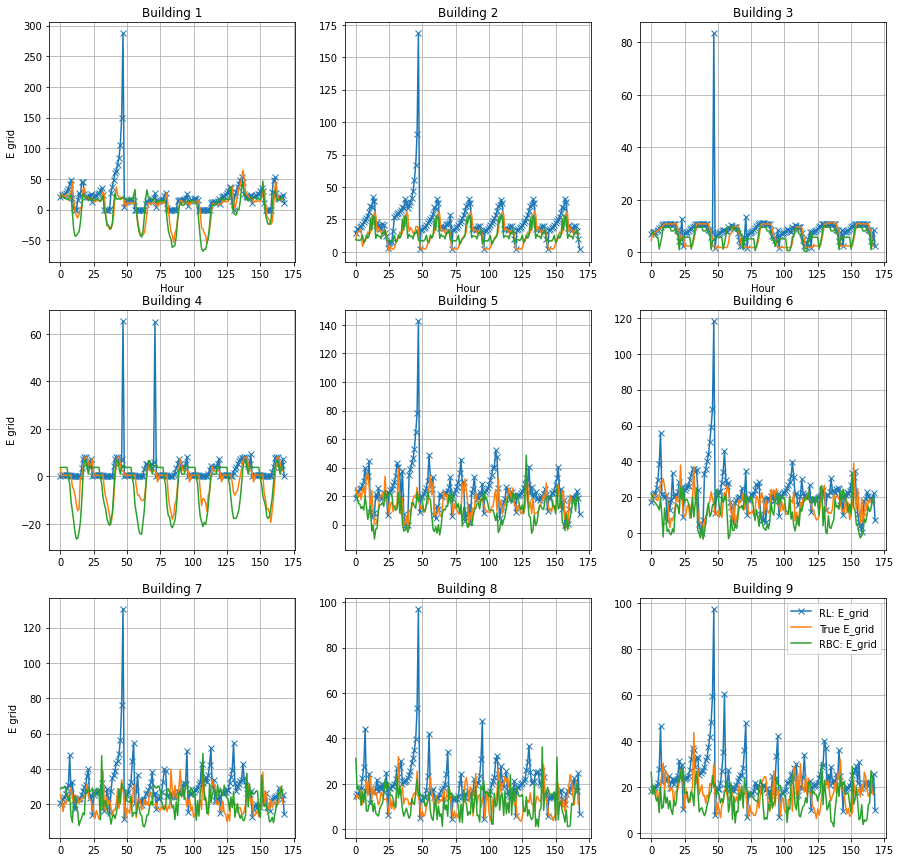

In [4]:
############## TODO: ENTER CODE HERE ##############

# list of dictionary of variables generated from RL. See actor.py#L166 for relevant variable names. eg. vars_RL[0]['E_grid']
# NOTE: dimensions of RL/NORL logger is ≠ RBC. This is because RL/NORL implicitly uses RBC. We only start collecting data from
# RL/NORL once it starts making inference, i.e, after `rbc_threshold`. Tweak the parameter above!

vars_RL = agents.logger

# list of dictionary of variables generated NORL - Optim w/o any RL. See actor.py#L166 for relevant variable names. eg. vars_RL[0]['E_grid']
vars_NORL = agents.norl_logger

# true E-grid values. NOTE: E_grid = E_grid_true. E_grid_pred = var["E_grid"] for RL/Optim
E_grid_true = np.array(E_grid_true)

# E_grid net electricity consumption per building using RBC

############## TODO: ENTER CODE HERE ##############


# vars_RL = np.array(vars_RL)  # DImension - No.of days
# RL_SOC_C = np.flatten(vars_RL[:]['SOC_C']).reshape(24*30,9)
# RL_SOC_C.append(vars_RL[i]['SOC_C'])

# #If indexing error, use the for loop
# RL_SOC_C.append( vars_RL[i][key] )
# RL_SOC_C = np.array(RL_SOC_C).flatten().reshape(days * 24, 9)


# vars_A, vars_B, ..., vars_Z = [], [], ..., [] # RL
# vars_A, vars_B, ..., vars_Z = [], [], ..., [] # NORL  #Already Defined

# 1. RBC Agent
RBC_actions_arr = []
RBC_look_ahead_cost = []  
RBC_E_grid_pred = []
RBC_E_grid_sell = []
RBC_E_hpC = []
RBC_E_ehH = []
RBC_Edhw = []
RBC_SOC_bat = []
RBC_SOC_C = []
RBC_SOC_H = []
RBC_C_p_bat = []
RBC_C_p_Csto = []
RBC_C_p_Hsto = []
RBC_ramping_cost = []
RBC_peak_electricity_cost = []
RBC_total_cost = []
RBC_action_C = []
RBC_action_H = []
RBC_action_bat = []

# 2. RL Agent
RL_actions_arr = []
RL_look_ahead_cost = [] 
RL_E_grid_sell = []
RL_E_grid_pred = []
RL_E_hpC = []
RL_E_ehH = []
RL_Edhw = []
RL_SOC_bat = []
RL_SOC_H = []
RL_SOC_C = []
RL_C_p_bat = []
RL_C_p_Csto = []
RL_C_p_Hsto = []
RL_ramping_cost = []
RL_peak_electricity_cost = []
RL_total_cost = []
RL_action_C = []
RL_action_H = []
RL_action_bat = []

# 3. NO RL Agent (Just Optimization)
NORL_actions_arr = []
NORL_look_ahead_cost = []
NORL_E_grid_sell = []
Egrid = []  
NORL_E_grid_pred = []
NORL_E_hpC = []
NORL_E_ehH = []
NORL_Edhw = []
NORL_SOC_bat = []
NORL_SOC_C = []
NORL_SOC_H = []
NORL_C_p_bat = []
NORL_C_p_Csto = []
NORL_C_p_Hsto = []
NORL_ramping_cost = []
NORL_peak_electricity_cost = []
NORL_total_cost = []
NORL_action_C = []
NORL_action_H = []
NORL_action_bat = []


# keys = list("E_grid", "E_grid_sell", "E_hpC", "E_ehH", "SOC_bat", "SOC_H", "SOC_C", " action_bat", "action_H", "action_C") 



for i in range(len(vars_RL)): #number of days of RL/NORL
    for j in range (9):
        RL_E_grid_pred.append(vars_RL[i][j]["E_grid"])
        RL_E_grid_sell.append(vars_RL[i][j]["E_grid_sell"])
        RL_E_hpC.append(vars_RL[i][j]["E_hpC"])
        RL_E_ehH.append(vars_RL[i][j]['E_ehH'])
        RL_SOC_bat.append(vars_RL[i][j]["SOC_bat"])
        RL_SOC_H.append(vars_RL[i][j]["SOC_H"])
        RL_SOC_C.append(vars_RL[i][j]["SOC_C"])
        RL_action_bat.append(vars_RL[i][j]["action_bat"])
        RL_action_C.append(vars_RL[i][j]["action_C"])
        RL_action_H.append(vars_RL[i][j]["action_H"])

# ### flatten out to get hour per building

RL_E_grid_pred = np.array(RL_E_grid_pred).flatten().reshape(-1, 9) # hours x num_buildings
RL_E_grid_sell = np.array(RL_E_grid_sell).flatten().reshape(-1, 9) # hours x num_buildings



# plot predicted E_grid
# week = end_time - 24 * 3  # plots last week of the month data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        bid = i * 3 + j
        axs[i, j].set_title(f"Building {bid + 1}")
        axs[i, j].plot(
            RL_E_grid_pred[:,i*3+j] + RL_E_grid_sell[:,i*3+j], label="RL: E_grid", marker='x'
        )
        axs[i, j].plot(
            E_grid_true[RBC_THRESHOLD:,i*3+j], label="True E_grid"
        )  # plot true E grid
        axs[i, j].plot(
            E_grid_RBC[RBC_THRESHOLD:,i*3+j], label="RBC: E_grid"
        )  # plot true E grid
        axs[i, j].grid()
        if j == 0:
            axs[i, j].set_ylabel("E grid")
        if i == 0:
            axs[i, j].set_xlabel("Hour")
plt.legend()
plt.show()


In [5]:
np.array(agents.data_loader.state_buffer.get(-2)["elec_cons"]).shape

(24, 9)

In [6]:
a = RL_E_grid_pred[:-1] + RL_E_grid_sell[:-1]
b = E_grid_true[RBC_THRESHOLD:]
c = E_grid_RBC[RBC_THRESHOLD:]

In [7]:
a.shape, b.shape, c.shape

((168, 9), (168, 9), (168, 9))

In [8]:
np.linalg.norm(a - b)

653.1023807314282